In [2]:
import numpy as np
import matplotlib.pyplot as plt
import requests
from datetime import datetime
import pandas as pd

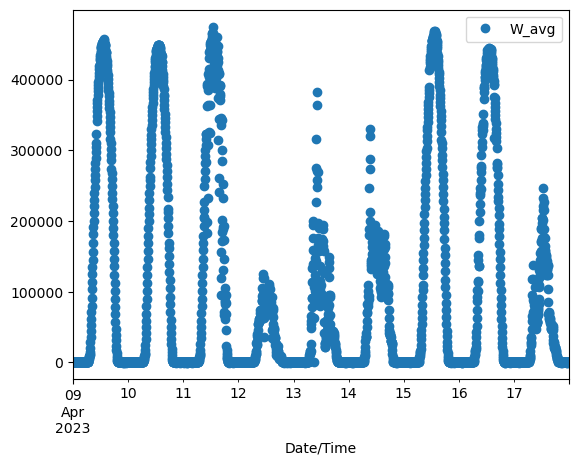

In [14]:
######################################################################
# Software to interface with the Thacher Solar Array
#
# To do:
# ------
# 1. Make parse_data flexible to allow mulitple fields in pandas
#    dataframe
#
#
# History:
# --------
# 2017Apr01: Work out basic protocol for API requests and separate
# (jswift)   tasks into 5 functions. End result is a pandas dataframe
#            with a datetime object in the first column and the other
#            variables of interest in following columns.
#
######################################################################


client_id='7868676c08a1b6b823063dcf3a97b637'
client_secret='8cbfcdcfa5ea17fed2a66ba7fc13a7af'
username = 'jswift@thacher.org'
password = 'Q78EGI867'
partner_id='581184'

#---------------------------------------------------------------------
def refresh_token():
    '''
    refresh_token
    -------------
    Uses hardwired username, password and identification
    to renew the access token for API requests

    Inputs
    ------
    None

    '''

    # Header and URL
    init_header = {'Content-type': 'application/x-www-form-urlencoded'}
    token_url = 'https://api.locusenergy.com/oauth/token'

    # Data to be added to  web request
    din = {'grant_type': 'password', 'client_id': client_id,
               'client_secret': client_secret, 'username': username,
               'password': password}

    # Refresh access token
    r = requests.post(token_url,headers=init_header,data=din)

    # Extract relevant information 
    token = {'access_token':str(r.json()['access_token']),
            'refresh_token':str(r.json()['refresh_token'])}

    return token



#---------------------------------------------------------------------
def get_ids(token):
    '''
    Get the node and component IDs for Thacher Solar Array
    '''
    # Header and URL
    headers = {'Accept': 'application/json',
               'Authorization': 'Bearer '+token['access_token']}
    node_url = 'https://api.locusenergy.com/v3/partners/'+ \
               partner_id+'/components'

    # Send request
    r = requests.get(node_url,headers=headers)

    # Extract relevant information
    ids = {'node_id': str(r.json()['components'][0]['nodeId']),
           'component_id': str(r.json()['components'][0]['id']) }

    return ids


#---------------------------------------------------------------------
def available(token,ids,verbose=True):
    '''
    Returns a dictionary with the variable names and their availability
    '''
    
    # Header and URL
    avail_url = 'https://api.locusenergy.com/v3/components/'+ \
                ids['component_id']+'/dataavailable'
    headers = {'Accept': 'application/json',
               'Authorization': 'Bearer '+token['access_token']}

    avail = requests.get(avail_url,headers=headers)
    # "avail" contains an extensive dictionary with the availability
    # of the data

    # Extract longnames and shortnames of available variables.
    longnames = []
    for base in avail.json()['baseFields']:
        longnames.append(str(base['longName']))

    shortnames = []
    for base in avail.json()['baseFields']:
        shortnames.append(str(base['aggregations'][0]['shortName']))

    # If verbose, print out long and short names to terminal
    if verbose:
        print("Available data:")
        print('---------------')
        for i in range(len(longnames)):
            print(longnames[i]+'   ||   '+shortnames[i])

    return avail.json()
        

#---------------------------------------------------------------------
def get_data(token,ids,start=[2017,1,1,0,0,0],stop=[2017,1,2,0,0,0],
             gran='5min',fields=['W_avg']):
    '''
    Request and return data for solar array for given fields at given 
    granularity (in time).
    '''
    
    # Header and url
    headers ={'Accept': 'application/json',
              'Authorization': 'Bearer '+token['access_token']}
    data_url = 'https://api.locusenergy.com/v3/components/'+ \
               ids['component_id']+'/data'

    # Format fileds as comma separated string
    fs = ''
    for f in fields:
        fs = fs+f+','
    fs = fs[:-1]

    # Format the time appropriately '2017-01-01T00:00:00'
    stime = str(start[0])+'-'+"%02d" % start[1]+'-'+"%02d" % start[2]+'T'+\
            "%02d" % start[3]+':'+"%02d" % start[4]+':'"%02d" % start[5]
    ftime = str(stop[0])+'-'+"%02d" % stop[1]+'-'+"%02d" % stop[2]+'T'+\
            "%02d" % stop[3]+':'+"%02d" % stop[4]+':'"%02d" % stop[5]
    
    # Specify parameters of call
    params = {'start':stime, 'end': ftime, 'tz':'US/Pacific',
              'gran':gran, 'fields':fs}

    # Send request and return result
    data = requests.get(data_url, headers=headers, params=params)

    return data.json()


#---------------------------------------------------------------------
def parse_data(data,field):
    '''
    Given data dictionary and field this function will parse the 
    ditionary into a simple pandas data frame

    Needs to be expanded to allow for multiple fields to be placed
    in the dataframe
    '''
    dtype = type(data['data'][0][field])
    dvec = np.array([]).astype(dtype)
    
    # Timestamps have appended values that are excluded here
    dt = []
    for d in data['data']:
        dvec = np.append(dvec,d[field])
        dt.append(datetime.strptime(str(d['ts'])[:-6],"%Y-%m-%dT%H:%M:%S"))

    par_data = {'Date/Time':dt, field: dvec}

    DF = pd.DataFrame.from_dict(par_data)
    
    return DF


#---------------------------------------------------------------------
def plot_data(DF,field):
    DF.plot(style='o',x='Date/Time',y=field)
    return


# Get and parse data 
data = get_data(refresh_token(),get_ids(refresh_token()),
                start=[2023,4,9,0,0,0],stop=[2023,4,18,0,0,0])
DF = parse_data(data,'W_avg')

# Plot data
plot_data(DF,'W_avg')
